# Stats Notebook
1. Root-To-Tip Distance
  - All
  - Clade

---
# 1. SETUP

## Modules

In [14]:
import os
import pandas as pd
import geopandas
import shapely
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy
import datetime
from Bio import AlignIO, Phylo
import seaborn as sns
import subprocess
import geopy
from geopy import distance
from statsmodels.stats.outliers_influence import summary_table
import statsmodels.api as sm
#import statsmodels.formula.api as sm
import math

from functions import *

## Paths

In [2]:
try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "full", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
      
results_dir = os.path.join(project_dir, "results/")

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

In [3]:
augur_dir   = os.path.join(results_dir, "augur/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))
iqtree_dir    = os.path.join(results_dir, "iqtree/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))

metadata_path = augur_dir + "metadata.tsv"

# ------------------------------------------
# Alignment
divtree_path              = augur_dir  + "all.divtree.nwk"

# ------------------------------------------
# Alignment
constant_sites_path   = results_dir + "snippy_multi/all/chromosome/full/snippy-multi.constant_sites.txt"
aln_path              = iqtree_dir + "filter-sites/snippy-multi.snps.aln"

# ------------------------------------------
# Output
out_dir = os.path.join(results_dir, "figures/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))
if not os.path.exists(out_dir):
    subprocess.run(["mkdir", "-p", out_dir]) 

## Variables

In [4]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

np.random.seed(1235423134)

NO_DATA_CHAR = "NA"

ALPHA = 0.05

# ------------------------------------------
# Time
CURRENT_YEAR = datetime.datetime.utcnow().year

# ------------------------------------------
# Geo
CRS = "epsg:3857"
CRS_EPSG = ccrs.epsg('3857')
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# ------------------------------------------
# Alignment
with open(constant_sites_path) as infile:
    data = infile.read().strip().split(",")
    constant_sites = sum([int(count) for count in data])

aln = AlignIO.read(aln_path, "fasta")
variant_sites = len(aln[0].seq)
SEQ_LEN = constant_sites + variant_sites

# ------------------------------------------
# Plotting
SM_FONT = 4
MED_FONT = 6
LG_FONT = 8
D3_PAL = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf" ]

# ------------------------------------------
BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"], 
    "0.PE": ["0.PE4m", "0.PE4m", "0.PE4t", "0.PE4a", "0.PE5"],   
    "0.ANT": ["0.ANT1", "0.ANT2","0.ANT3","0.ANT5"],     
    "1.PRE" : ["1.PRE1", "1.PRE2", "1.PRE3"],    
    "1.ANT": ["1.ANT1"], 
    "1.IN": ["1.IN1","1.IN2","1.IN3"],   
    "1.ORI" : ["1.ORI1", "1.ORI2", "1.ORI3"],
    "2.ANT": ["2.ANT1","2.ANT2","2.ANT3" ], 
    "2.MED": ["2.MED0", "2.MED1","2.MED2","2.MED3" ], 
    "3.ANT": ["3.ANT1", "3.ANT2" ],     
    "4.ANT": ["4.ANT1" ],           
}

ANCIENT_BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"],  
    "1.PRE" : ["1.PRE1", "1.PRE2", "1.PRE3"],     
}

MUG_ATTRIBUTE_LIST = [
    "branch_major",
    "branch_minor",
    "country",
    "province",
]

---
# 1. IMPORT

## Trees

In [5]:
divtree = Phylo.read(divtree_path, "newick")

## Metadata

In [6]:
metadata_df = pd.read_csv(metadata_path, sep='\t', index_col = 0)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)
# Erase geometry column
metadata_df.drop(columns=["geometry"], inplace=True)

## Convert Dataframe to Geopandas

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,branch_support_char,node_type,branch_length,branch_support,timetree_date,timetree_CI_height,timetree_CI_date,mugration_country,mugration_province,mugration_branch_major,mugration_branch_minor,mugration_country_confidence,mugration_province_confidence,mugration_branch_major_confidence,mugration_branch_minor_confidence,mugration_country_lat,mugration_country_lon,mugration_province_lat,mugration_province_lon,geometry_size,date_lower,date_upper,divtree_coord_x,divtree_coord_y,rtt_dist,branch_major_color,timetree_coord_x,timetree_coord_y,timetree_date_calendar,timetree_CI_lower_err,timetree_CI_upper_err,root_rtt_dist,clade_rtt_dist,geometry
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992,29,0,38.7252,-105.608,NA,terminal,4.004600e-06,100.0,-29.0000,NA,NA,United States of America,Colorado,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,39.783730,-100.445882,38.725178,-105.607716,1.0,1992,1992,0.000073,509.00,0.000073,#ff0000,6330.17150,509.00,1992.0,0.0,0.0,0.000073,0.000006,POINT (-105.60772 38.72518)
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923,98,0,47.6222,40.7958,NA,terminal,2.120100e-06,100.0,-98.0000,NA,NA,Russia,Rostov Oblast,2.MED,2.MED1,1.0,1.00,1.0,1.0,64.686314,97.745306,47.622245,40.795794,4.0,1923,1923,0.000073,339.00,0.000073,#b3f396,6261.17070,339.00,1923.0,0.0,0.0,0.000073,0.000010,POINT (40.79579 47.62225)
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006,15,0,42.4805,85.4633,NA,terminal,0.000000e+00,100.0,-15.0000,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.0,1.00,1.0,1.0,35.000074,104.999927,42.480495,85.463346,105.0,2006,2006,0.000054,152.00,0.000054,#1996f3,6344.17477,152.00,2006.0,0.0,0.0,0.000054,0.000012,POINT (85.46335 42.48050)
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,NA,terminal,2.356000e-07,100.0,-16.0000,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.0,1.00,1.0,1.0,35.000074,104.999927,42.480495,85.463346,105.0,2005,2005,0.000055,171.00,0.000055,#1996f3,6343.17481,171.00,2005.0,0.0,0.0,0.000055,0.000012,POINT (85.46335 42.48050)
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005,16,0,42.4805,85.4633,NA,terminal,4.711000e-07,100.0,-16.0000,NA,NA,China,Xinjiang,0.ANT,0.ANT1,1.0,1.00,1.0,1.0,35.000074,104.999927,42.480495,85.463346,105.0,2005,2005,0.000055,173.00,0.000055,#1996f3,6343.17471,173.00,2005.0,0.0,0.0,0.000055,0.000012,POINT (85.46335 42.48050)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE595,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,2.207000e-07,13.0,-147.7590,"{116.143,181.767}","{-181.767,-116.143}",Peru,Cajamarca,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,-6.869970,-75.045851,-6.250000,-78.833333,18.0,NA,NA,0.000072,598.25,0.000072,#ff0000,6211.41227,598.25,1874.0,34.0,31.0,0.000072,0.000005,POINT (-78.83333 -6.25000)
NODE596,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,internal,2.356000e-07,13.0,-147.7590,"{116.143,181.767}","{-181.767,-116.143}",Peru,Cajamarca,1.ORI,1.ORI1,1.0,1.00,1.0,1.0,-6.869970,-7

<GeoAxesSubplot:>

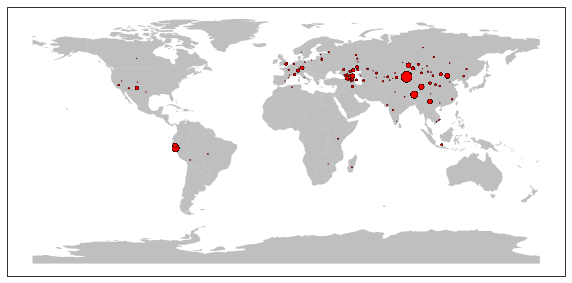

In [7]:
geometry = []
# Erase geometry column
for rec in metadata_df.iterrows():
    sample = rec[0]
    lat = rec[1]["mugration_province_lat"]
    lon = rec[1]["mugration_province_lon"]
    point = shapely.geometry.Point(lon,lat)
    geometry.append(point)
    
metadata_gdf = geopandas.GeoDataFrame(metadata_df, crs="epsg:3857", geometry=geometry)

display(metadata_gdf)

# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=(10, 5))
world_polygons.plot(ax=ax, color="grey", alpha=0.5)
metadata_gdf.plot(ax=ax, c="red", markersize="geometry_size", ec="black", lw=0.25)

---
# 2. RTT (Root-To-Tip Regression)

In [17]:
def linregress_bootstrap(x,y, nboots=100):
    """
    Bootstrap a linear regression.
    """
    #bootstrap_dict = {"x": [], "y": [], "slopes" : [], "intercepts": []}
    # Add constant
    X = sm.add_constant(x)
    
    # Construct a likear model
    model = sm.OLS(y,X)
    results = model.fit()
    print(results)
    #y_pred = results.predict(reg_df['x'])
    #resids = results.resid
    
    """return bootstrap_dict
    
    for _ in range(n_boots):
        # create a sampling of the residuals with replacement
        boot_resids = np.random.choice(resids, len(x), replace=True)
        y_temp = [y_pred_i + resid_i for y_pred_i, resid_i in zip(y_pred, boot_resids)]

        sample_df = pd.DataFrame({'x': x, 'y': y_temp})
        # Fit a linear regression
        ols_model_temp = sm.ols(formula = 'y ~ x', data=sample_df)
        results_temp = ols_model_temp.fit()

        # get coefficients
        boot_intercepts.append(results_temp.params[0])
        boot_slopes.append(results_temp.params[1])

        # plot a greyed out line
        y_pred_temp = ols_model_temp.fit().predict(sample_df['x'])
        row = pd.DataFrame({'x': x, 'y': y_pred_temp})
        boot_df = boot_df.append(row) 
        
    
    # Y = mx +b ; x = (y - b)/m
    boot_y_intercepts = []
    for boot_slope, boot_intercept in zip(boot_slopes, boot_intercepts):
        boot_y_intercepts.append((0 - boot_intercept) / boot_slope)"""
    
linregress_bootstrap(x,y,nboots=100)

In [12]:
print(x)

[1560.0, 1560.0, 1560.0, 1560.0, 1560.0, 1560.0, 1560.0, 1560.0, 1525.0, 1505.5, 1342.0, 1336.5, 1543.5, 1556.0, 1633.0, 1597.5, 1597.5, 1597.5, 1597.5, 1334.0, 1330.0, 1350.0, 1350.0, 1381.0, 1360.0, 1721.0, 1721.0, 1721.0, 1721.0, 1721.0, 1349.0, 1350.0, 1650.0, 1767.5, 1550.0, 1550.0, 1456.0, 1526.5, 1547.5]


## All

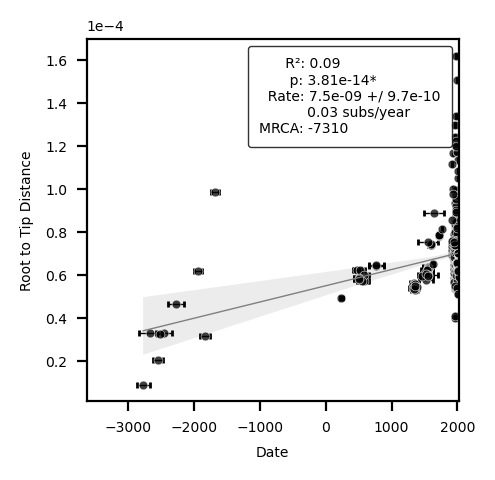

In [9]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

geo_dist_all = []
genetic_dist_all = []

fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)

df = metadata_gdf[(metadata_gdf["node_type"] == "terminal") & (metadata_gdf["date_mean"] != NO_DATA_CHAR)]
reg_x = "date_mean"
reg_y = "root_rtt_dist"
reg_err = "date_err"

# -----------------------
# Regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(list(df[reg_x]),list(df[reg_y]))
r2 = r_value * r_value    
y_intercept = CURRENT_YEAR - (0 - intercept)/slope
p_sig = ""
if p_value < ALPHA:
    p_sig = "*"

sub_per_year = SEQ_LEN * slope
year_per_sub = 1 / sub_per_year
y_intercept_calendar = CURRENT_YEAR - y_intercept

sns.regplot(
    ax=ax,
    data=df, 
    x=list(df[reg_x]), 
    y=list(df[reg_y]), 
    ci=95,
    scatter_kws={"s": 0},
    line_kws={"linewidth" : 0.5},
    color="grey",
    #color=df["branch_major_color"][0],
    label=(
    "      R²: {}".format(round(r2,2))
    + "\n       p: {:.2e}{}".format(p_value, p_sig)
    + "\n  Rate: {:.2} +/ {:.2}".format(slope, std_err)  
    + "\n           {} subs/year".format(round(sub_per_year, 2))
    + "\nMRCA: {}".format(round(y_intercept_calendar))                
    )
)


ax.errorbar(
    data=df, 
    x=reg_x, 
    y=reg_y, 
    xerr=reg_err,
    yerr=None,
    ls='none',
    c = "black",  
    capsize=1,
    label=None,
    zorder=1,
    lw=0.5,
    )  

sns.scatterplot(
    ax=ax,
    data=df, 
    x=reg_x, 
    y=reg_y, 
    s=10,    
    ec = "white", 
    color="black",
    alpha=0.75,
    zorder=2,
) 


# Set xlimits
xlim = ax.get_xlim()
x_buff = round((xlim[1] - xlim[0]) * 0.1,1)
new_xlim = [xlim[0]-x_buff, xlim[1]+x_buff]

if new_xlim[1] > CURRENT_YEAR:
    new_xlim = [new_xlim[0], CURRENT_YEAR]
ax.set_xlim(new_xlim)
    
ax.set_ylabel("Root to Tip Distance")
ax.set_xlabel("Date")    
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 

# Format and position legend
legend = ax.legend(
    borderpad=0.8, 
    handletextpad=-2, 
    edgecolor="black", 
    #bbox_to_anchor=(0.5, -0.30), 
    #loc='center',
    fontsize=FONTSIZE,
)
frame = legend.get_frame().set_linewidth(0.5)

out_path = os.path.join(out_dir, "rtt_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Clades

Branch: 1.PRE
1308.6533545677814 1381.1222497565084


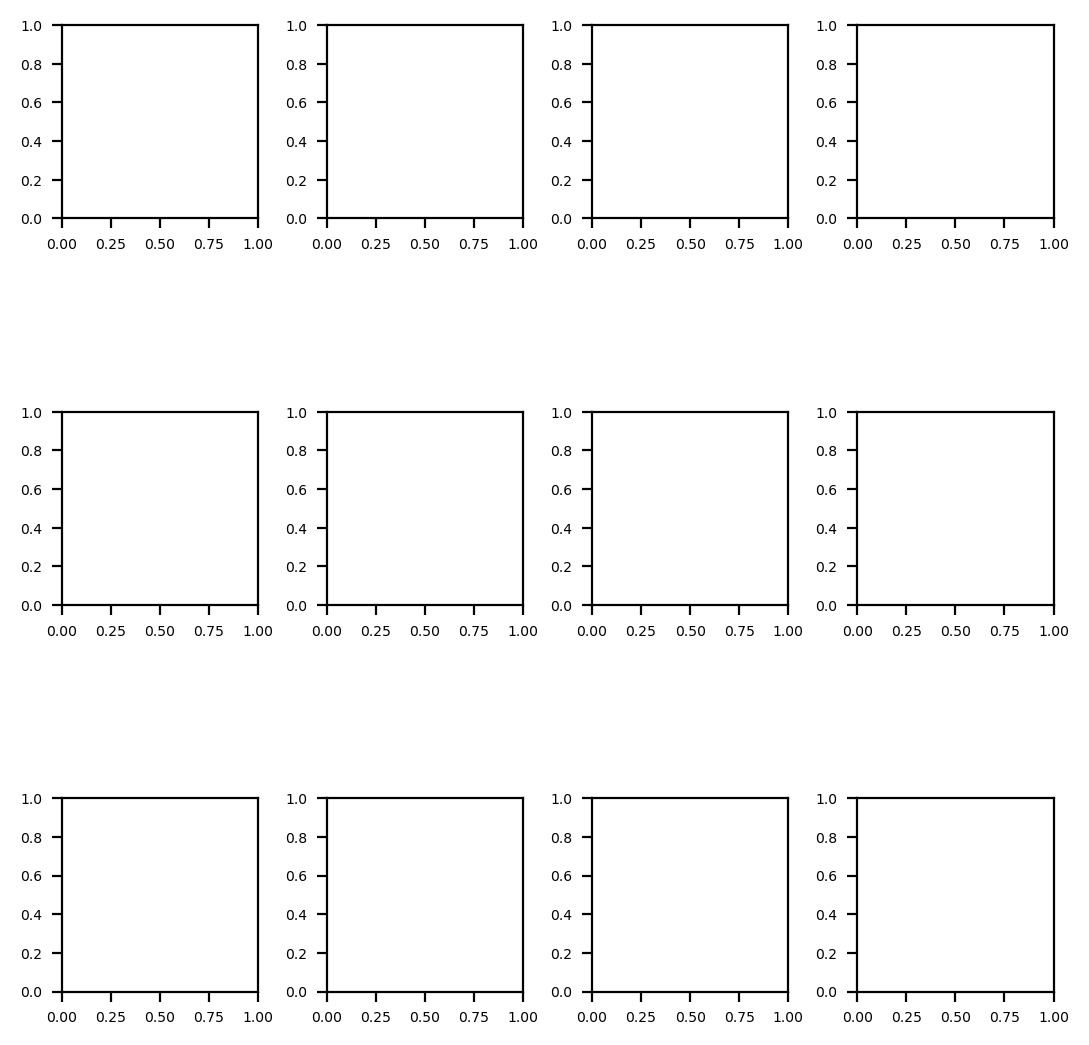

In [11]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

reg_x = "date_mean"
reg_y = "clade_rtt_dist"
reg_err = "date_err"

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=1)

i_row = 0
i_col = 0

for label in BRANCH_LIST:
    if label != "1.PRE": continue
    print("Branch:", label)
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = copy.copy(metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])])
    x = list(df[reg_x])
    y = list(df[reg_y])
    # If no records for this branch, continue
    if len(df) < 2: 
        # Update axis
        if i_col == ncol - 1:
            i_col = 0
            i_row += 1
        else:
            i_col += 1        
        continue

    """
    # -----------------------
    # Detect Outliers
    x = list(df[reg_x])
    y = list(df[reg_y])
    fit = smapi.OLS(x,y).fit()
    test = fit.outlier_test()
    outliers = ((x[i],y[i]) for i,t in enumerate(test) if t[2] < 0.05)
    for o in outliers:
        ox = o[0]
        oy = o[1]
        # Find the matching sample
        sample = df[(df[reg_x] == ox) & (df[reg_y] == oy)].index[0]
        df.drop(index=sample, inplace=True)
    """
    
    # -----------------------
    # Regression
    #slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    linear_reg = scipy.stats.linregress(x,y)
    r_value = linear_reg.rvalue
    slope = linear_reg.slope
    intercept = linear_reg.intercept
    p_value = linear_reg.pvalue
    std_err = linear_reg.stderr
    
    r2 = r_value**2 
    y_intercept = CURRENT_YEAR - (0 - intercept)/slope
    p_sig = ""
    if p_value < ALPHA:
        p_sig = "*"
        
    sub_per_year = SEQ_LEN * slope
    year_per_sub = 1 / sub_per_year    
    y_intercept_calendar = CURRENT_YEAR - y_intercept
    

    # -----------------------
    # Resampling
    reg_df = data_df = pd.DataFrame({'x': x, 'y': y})
    ols_model = sm.ols(formula = 'y ~ x', data=reg_df)
    results = ols_model.fit()
    y_pred = results.predict(reg_df['x'])
    resids = results.resid
    
    boot_slopes = []
    boot_intercepts = []
    boot_df = pd.DataFrame({'x': [], 'y': []})
    n_boots = 100
    for _ in range(n_boots):
        # create a sampling of the residuals with replacement
        boot_resids = np.random.choice(resids, len(x), replace=True)
        y_temp = [y_pred_i + resid_i for y_pred_i, resid_i in zip(y_pred, boot_resids)]

        sample_df = pd.DataFrame({'x': x, 'y': y_temp})
        # Fit a linear regression
        ols_model_temp = sm.ols(formula = 'y ~ x', data=sample_df)
        results_temp = ols_model_temp.fit()

        # get coefficients
        boot_intercepts.append(results_temp.params[0])
        boot_slopes.append(results_temp.params[1])

        # plot a greyed out line
        y_pred_temp = ols_model_temp.fit().predict(sample_df['x'])
        row = pd.DataFrame({'x': x, 'y': y_pred_temp})
        boot_df = boot_df.append(row) 
        
    
    # Y = mx +b ; x = (y - b)/m
    boot_y_intercepts = []
    for boot_slope, boot_intercept in zip(boot_slopes, boot_intercepts):
        boot_y_intercepts.append((0 - boot_intercept) / boot_slope)
    print(min(boot_y_intercepts), max(boot_y_intercepts))
    #ax.plot(boot_df['x'], boot_df['y'], color='grey', alpha=0.25)    
    break
     

    sns.regplot(
        ax=ax,
        data=df, 
        x=list(df[reg_x]), 
        y=list(df[reg_y]), 
        ci=95,
        scatter_kws={"s": 0},
        line_kws={"linewidth" : 0.5},
        color="grey",
        #color=df["branch_major_color"][0],
        label=(
        "      R²: {}".format(round(r2,2))
        + "\n       p: {:.2e}{}".format(p_value, p_sig)
        + "\n  Rate: {:.2} +/ {:.2}".format(slope, std_err)  
        + "\n           {} subs/year".format(round(sub_per_year, 2))
        + "\nMRCA: {}".format(round(y_intercept_calendar))                
        )
    )

    ax.errorbar(
        data=df, 
        x=x, 
        y=y, 
        xerr=list(df[reg_err]),         
        yerr=None,
        ls='none',
        c = df["branch_major_color"][0],  
        capsize=1,
        label=None,
        zorder=1,
        lw=0.5,
        )  
    
    sns.scatterplot(
        ax=ax,
        data=df, 
        x=x, 
        y=y,   
        s=10,
        c = df["branch_major_color"], 
        ec = "black",
        alpha=0.75,
        zorder=2,
    )
    
    # Set xlimits
    xlim = ax.get_xlim()
    x_buff = round((xlim[1] - xlim[0]) * 0.1,1)
    new_xlim = [xlim[0]-x_buff, xlim[1]+x_buff]
    if new_xlim[1] > CURRENT_YEAR:
        new_xlim = [new_xlim[0], CURRENT_YEAR]
    ax.set_xlim(new_xlim)

    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.55), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)
        
    # Format axis
    ax.set_title(label)

    if i_col == 0:
        ax.set_ylabel("Root to Tip Distance")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1
        
    
out_path = os.path.join(out_dir, "rtt_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

---
# 3. IBD (Isolation By Distance)

## Calculate

In [ ]:
ibd_dict = {}

for label in BRANCH_LIST:
    print("Label:", label)    
    ibd_dict[label] = {"geo_dist" : [], "genetic_dist" : []}
    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]   
    
    i_compare = 0
    i = 0
    for sample1 in df.index:
        geom1 = df["geometry"][sample1]
        coord1 = (geom1.y, geom1.x)  
        for sample2 in df.index[i_compare:]:
            if sample1 == sample2: continue
            geom2 = df["geometry"][sample2]
            coord2 = (geom2.y, geom2.x)
            geo_dist = geopy.distance.great_circle(coord1, coord2).km
            genetic_dist = divtree.distance(sample1, sample2)

            ibd_dict[label]["geo_dist"].append(geo_dist)
            ibd_dict[label]["genetic_dist"].append(genetic_dist)
        i_compare += 1

# All

In [ ]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

geo_dist_all = []
genetic_dist_all = []

fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)

for branch in ibd_dict:
    geo_dist_all = geo_dist_all + ibd_dict[branch]["geo_dist"]
    genetic_dist_all = genetic_dist_all + ibd_dict[branch]["genetic_dist"]

sns.regplot(
    ax=ax,
    x=geo_dist_all,
    y=genetic_dist_all,
    ci=95,
    scatter_kws={"s": 0},
    color="grey",
    line_kws={"linewidth":0.5},
    label=(
    "   R²: {}".format(round(r2,2))
    + "\n     p: {:.2e}{}".format(p_value, p_sig)             
    )
)
    
sns.scatterplot(
    ax=ax,
    x=geo_dist_all,
    y=genetic_dist_all,
    s=1,
    ec = "white", 
    color="black",
    alpha=0.75,
    zorder=2,
)

# Format and position legend
legend = ax.legend(
    borderpad=0.8, 
    handletextpad=-2, 
    edgecolor="black", 
    #bbox_to_anchor=(0.5, -0.30), 
    #loc='center',
    fontsize=FONTSIZE,
)
frame = legend.get_frame().set_linewidth(0.5)

ax.set_ylabel("Genetic Distance (subs / site)")
ax.set_xlabel("Great Circle Distance (km)")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    

out_path = os.path.join(out_dir, "ibd_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Clades

In [ ]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=0.75)


i_row = 0
i_col = 0

for label in BRANCH_LIST:
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[label])]  
    
    if len(df) < 3:
        # Update axis
        if i_col == ncol - 1:
            i_col = 0
            i_row += 1
        else:
            i_col += 1        
        continue
    
    # -----------------------
    # Regression
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ibd_dict[label]["geo_dist"],ibd_dict[label]["genetic_dist"])
    r2 = r_value * r_value    
    y_intercept = CURRENT_YEAR - (0 - intercept)/slope
    p_sig = "" 
    if p_value < ALPHA:
        p_sig = "*"
        
    mut_per_year = SEQ_LEN * slope
    year_per_mut = 1 / mut_per_year
    
    reg_dict = {
        "slope": slope,
        "x_intercept" : intercept,
        "y_intercept" : y_intercept,
        "p_value" : p_value,
        "p_sig" : p_sig,
        "year_per_mut" : year_per_mut
    }
    
    sns.regplot(
        ax=ax,
        x=ibd_dict[label]["geo_dist"],
        y=ibd_dict[label]["genetic_dist"],
        ci=95,
        scatter_kws={"s": 0},
        color="grey",
        line_kws={"linewidth":0.5},
        label=(
        "   R²: {}".format(round(r2,2))
        + "\n     p: {:.2e}{}".format(p_value, p_sig)             
        )
    )

    sns.scatterplot(
        ax=ax,
        x=ibd_dict[label]["geo_dist"],
        y=ibd_dict[label]["genetic_dist"],
        s=10,
        ec = "black",
        color = df["branch_major_color"][0],         
        alpha=0.75,
        zorder=2,
    )
     
    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.40), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)        
    
    # Set xlimits
    xlim = ax.get_xlim()
    if xlim[1] > 20000:
        xbuff = 5000   
    elif xlim[1] > 2000:
        xbuff = 500
    elif xlim[1] > 200:
        xbuff = 50
    ax.set_xlim(0-xbuff, xlim[1] + xbuff)
        
    # Format axis
    ax.set_title(label)

    if i_col == 0:
        ax.set_ylabel("Genetic Distance (subs / site)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Great Circle Distance (km)")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1

    
out_path = os.path.join(out_dir, "ibd_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")